<a href="https://colab.research.google.com/github/peimani/Project4/blob/master/Copy_of_Image_Classification_w_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Recognition

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


# **Installs and Imports**

In [2]:
import numpy as np
import tensorflow as tf

np.random.seed(321)
tf.random.set_seed(321)

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys, glob

import datetime as dt
from sklearn import metrics
from tzlocal import get_localzone

In [4]:
from keras import models
from keras.models import load_model
from keras.preprocessing import image
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import callbacks, models, layers, optimizers, regularizers

## Load the Data

In [6]:
# Get the Directory Paths of the Image sets
train_img = '/content/drive/MyDrive/Colab Notebooks/Data_Files/train'
val_img = '/content/drive/MyDrive/Colab Notebooks/Data_Files/val'
test_img = '/content/drive/MyDrive/Colab Notebooks/Data_Files/test'

### Preview the Image

In [7]:

print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_img, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_img, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_img, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_img, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_img, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_img, 'NORMAL')))}")

Train set:
PNEUMONIA=3876
NORMAL=3804
Test set:
PNEUMONIA=390
NORMAL=234
Validation set:
PNEUMONIA=8
NORMAL=8


## Data Preparation

### Class Imbalance: 
  There are 1341 'NORMAL' chest x-rays and 3876 x-rays displaying 
  'PNEUMONIA'. To address is class imbalance I will have to generate 2,535 more NORMAL images to equal the 3876 images displaying PNEUMONIA.

In [8]:
# Establish the criteria for data augementation; create random transformation of images
datagen = ImageDataGenerator(
            rotation_range = 40,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            rescale = 1./255,
            shear_range = 0.2,
            zoom_range = 0.2,
            horizontal_flip = True,
            fill_mode = 'nearest')

In [9]:
# Select a random normal image to transform. Put the image path into load_img
img = load_img('/content/drive/MyDrive/Colab Notebooks/Data_Files/train/NORMAL/IM-0115-0001.jpeg')

In [10]:
#get the size of the image (2090x1858)
img.getpixel

<bound method Image.getpixel of <PIL.Image.Image image mode=RGB size=2090x1858 at 0x7F0C96D8C828>>

In [11]:
#convert the image to an array
img_array = img_to_array(img)

In [12]:
# Get the shape of the image array
img_array.shape

(1858, 2090, 3)

In [13]:
# Reshape the array to an (1 x n) array
img_array = img_array.reshape((1,) + img_array.shape)
img_array.shape

(1, 1858, 2090, 3)

In [14]:
# Store the file path to Generated Images Test to the variable "gen_dir"
gen_dir = '/content/drive/MyDrive/Colab Notebooks/Data_Files/Generated_Drafts'

In [18]:
# Add 90 "test" images to gen_dir in batches of 30 to verify that the code works as intended
count = 0
for batch in datagen.flow(img_array, batch_size=30, save_to_dir=gen_dir, save_prefix='IM', save_format='jpeg'):
    count +=1
    if count == 90:
        break
        
print('90 images have been generated at', gen_dir)

90 images have been generated at /content/drive/MyDrive/Colab Notebooks/Data_Files/Generated_Drafts


In [19]:
# Add the Normal X-ray Training file path
norm_dir = '/content/drive/MyDrive/Colab Notebooks/Data_Files/train/NORMAL'

# Add 2535 Images to the file path in batches of 150
count = 0
for batch in datagen.flow(img_array, batch_size=150, save_to_dir=norm_dir, save_prefix='IM', save_format='jpeg'):
    count +=1
    if count == 2535:
        break
        
print('2534 images have been generated at', norm_dir)

2534 images have been generated at /content/drive/MyDrive/Colab Notebooks/Data_Files/train/NORMAL


In [20]:
imgs_pneumonia = [file for file in os.listdir(norm_dir) if file.endswith('.jpeg')]
print('There are', len(imgs_pneumonia), ' PNEUMONIA images')

There are 4520  PNEUMONIA images


In [21]:
# The previous code block stopped 299 images short of 2535. This block, adds them to the Normal Chest Training File Path
count = 0
for batch in datagen.flow(img_array, batch_size=31, save_to_dir=norm_dir, save_prefix='IM', save_format='jpeg'):
    count +=1
    if count == 299:
        break
        
print('299 additional images have been generated at', norm_dir)

299 additional images have been generated at /content/drive/MyDrive/Colab Notebooks/Data_Files/train/NORMAL


## Preprocessing

### Read in Images

In [23]:
# Resize all 7685 images in the train directory
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(train_img,
                                                          target_size = (64, 64), batch_size= 7685)

Found 8586 images belonging to 2 classes.


In [24]:
# Resize all 16 images in the val directory
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_img,
                                                        target_size = (64, 64), batch_size=16)

Found 16 images belonging to 2 classes.


In [25]:
# Resize all 624 images in the val directory
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_img,
                                                          target_size = (64, 64), batch_size=624)

Found 624 images belonging to 2 classes.


In [26]:
# Iterate through all of the images and create image-label datasets stored into "X_images" and "X_labels"
train_images, train_labels = next(train_generator)

In [27]:

val_images, val_labels = next(val_generator)

In [31]:
test_images, test_labels = next(test_generator)

### Checking the shape of the image and label arrays

In [46]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("*******************************************")
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("*******************************************")
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("*******************************************")
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))
print ("*******************************************")

Number of training samples: 7685
Number of testing samples: 624
Number of validation samples: 16
*******************************************
train_images shape: (7685, 64, 64, 3)
train_labels shape: (7685, 2)
*******************************************
test_images shape: (624, 64, 64, 3)
test_labels shape: (624, 2)
*******************************************
val_images shape: (16, 64, 64, 3)
val_labels shape: (16, 2)
*******************************************


## Transform Label Maricies

In [47]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(7685, 12288)
(624, 12288)
(16, 12288)


In [48]:
print(train_labels.shape)
print(test_labels.shape)
print(val_labels.shape)

(7685, 2)
(624, 2)
(16, 2)


In [49]:
train_labels

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [50]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [51]:
train_y = np.reshape(train_labels[:,0], (train_labels.shape[0],1))
test_y = np.reshape(test_labels[:,0], (test_labels.shape[0],1))
val_y = np.reshape(val_labels[:,0], (val_labels.shape[0],1))
print(train_y.shape)
print(test_y.shape)
print(val_y.shape)

(7685, 1)
(624, 1)
(16, 1)


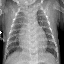

In [37]:
# Check with a random image 
array_to_img(train_images[3500])

## Modeling 

In [52]:
# Build a baseline fully connected model
model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(67500,))) # 2 hidden layers
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20)                1350020   
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 147       
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 6         
Total params: 1,350,213
Trainable params: 1,350,213
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [58]:
# Employ the earyl stopping callback to stop the model when the validation loss has stopped improving, then save the resulting model with the file name "best_model.h5"
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]


In [63]:
# Train the model
results = model.fit(train_img, train_y, epochs=100, callbacks=early_stopping, batch_size=500, validation_data=(val_img, val_y))


Epoch 1/100


ValueError: ignored

In [ ]:
train_generator.class_indices

In [ ]:
# Preview an Image
array_to_img(train_images[80])

In [ ]:
# Image 20
##array_to_img(train_img[-1])

def show_image(input_filepath, size):
    path = input_filepath
    img = image.load_img(path, target_size=(size, size))
    plt.imshow(img)
    plt.show()


In [ ]:
#normal image
show_image('/content/drive/MyDrive/Colab Notebooks/Data_Files/train/NORMAL/IM-0115-0001.jpeg', 150) 

In [ ]:
#bacterial pneumonia image
show_image('/content/drive/MyDrive/Colab Notebooks/Data_Files/train/PNEUMONIA/person1000_bacteria_2931.jpeg', 150)

In [ ]:
#viral pneumonia image
show_image('/content/drive/MyDrive/Colab Notebooks/Data_Files/train/PNEUMONIA/person1000_virus_1681.jpeg', 150)

## Transform the Images to a Tensor and Visualize Again

In [ ]:
# get the tensor form of input image
def transform_image2tensor(input_filepath, size, norm):
    
    path = input_filepath
    img = image.load_img(input_filepath, target_size=(size, size))
    file_tensor = image.img_to_array(img)
    file_tensor = np.expand_dims(file_tensor, axis=0)
    
    # Follow the Original Model Preprocessing
    file_tensor /= norm
    
    # Check tensor shape
    print(file_tensor.shape)
    
    # Preview an image
    plt.imshow(file_tensor[0])
    plt.show()
    
    return file_tensor

In [ ]:
#normal image in tensor
normal_tensor = transform_image2tensor('/content/drive/MyDrive/Colab Notebooks/Data_Files/train/NORMAL/IM-0115-0001.jpeg', 150, 255)

In [ ]:
# bacterial pneumonia image in tensor
normal_tensor = transform_image2tensor('/content/drive/MyDrive/Colab Notebooks/Data_Files/train/PNEUMONIA/person1000_bacteria_2931.jpeg', 150, 255)

In [ ]:
# viral pneumonia image in tensor
normal_tensor = transform_image2tensor('/content/drive/MyDrive/Colab Notebooks/Data_Files/train/PNEUMONIA/person1000_virus_1681.jpeg', 150, 255)